# Figure 1

/tmp/ipykernel_14923/1761087976.py:299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 1.0])


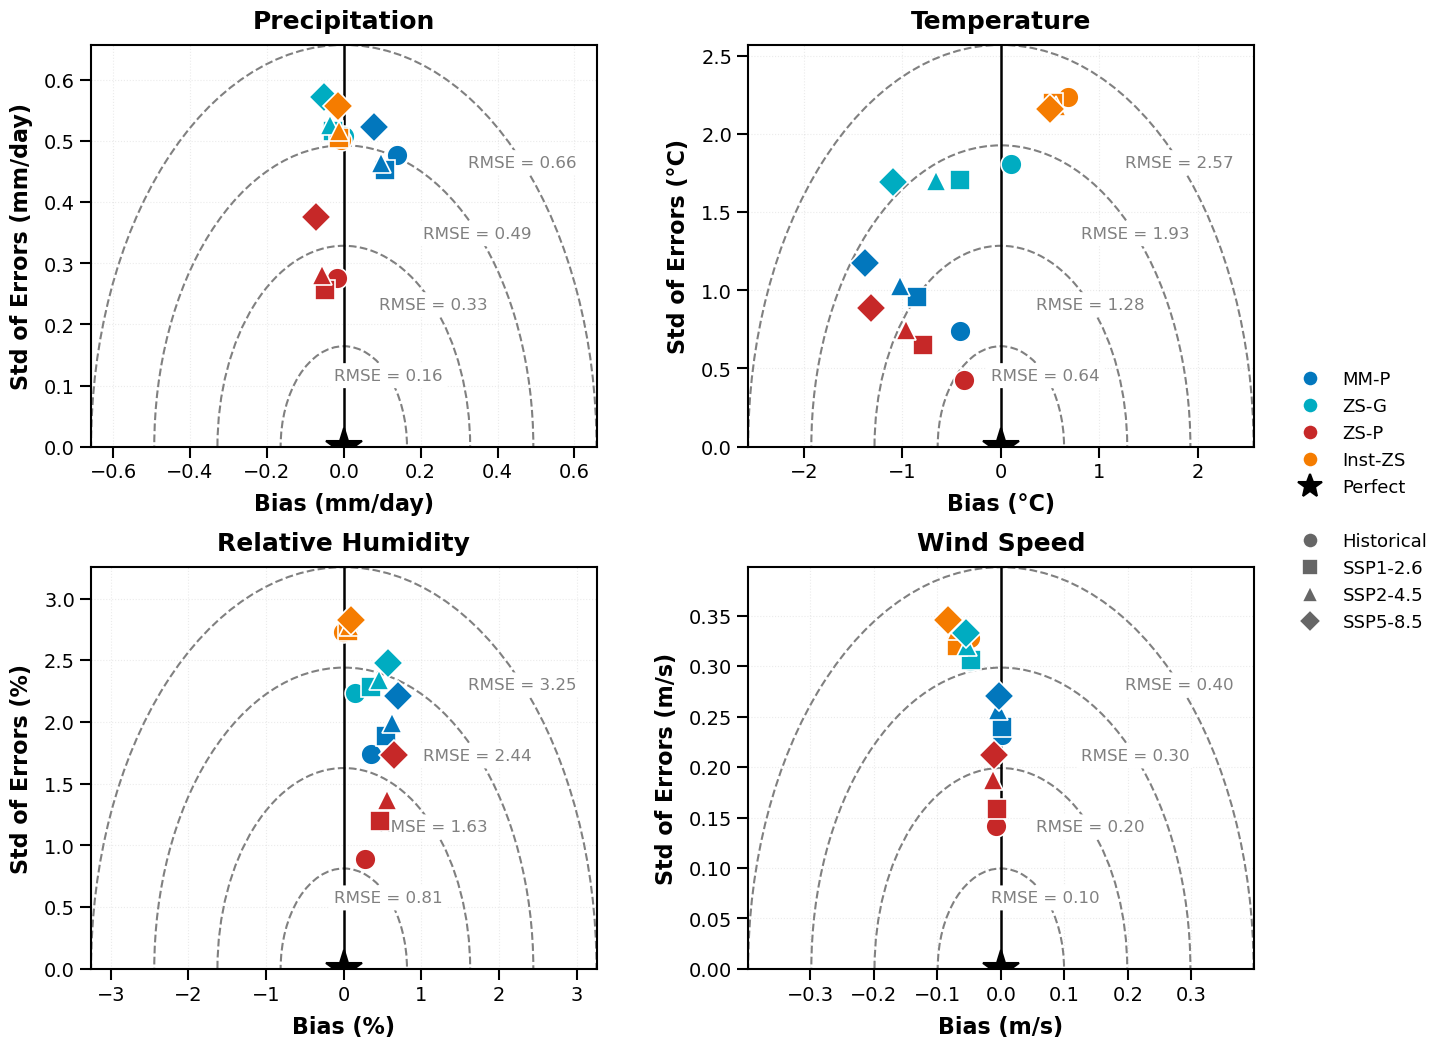

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import matplotlib.lines as mlines
from matplotlib.patches import Circle

# ----------------------------
# Configuration
# ----------------------------
results_dir = Path("../evaluation_results") 
figures_dir = Path("../Figures")             

variables = ['pr', 'tas', 'hurs', 'sfcWind']
scenarios = ['historical', 'ssp126', 'ssp245', 'ssp585']

# ONLY 4 normalization methods to compare
normalizations = ['minmax_pixel', 'zscore_global', 'zscore_pixel', 'instance_zscore']

# Variable configuration
var_config = {
    'pr': {'label': 'Precipitation', 'unit': 'mm/day'},
    'tas': {'label': 'Temperature', 'unit': '°C'},
    'hurs': {'label': 'Relative Humidity', 'unit': '%'},
    'sfcWind': {'label': 'Wind Speed', 'unit': 'm/s'}
}

# Normalization labels
norm_labels = {
    'minmax_pixel': 'MM-P',
    'zscore_global': 'ZS-G',
    'zscore_pixel': 'ZS-P',
    'instance_zscore': 'Inst-ZS'
}

# Scenario labels
scenario_labels = {
    'historical': 'Historical',
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

# Colors for normalization methods
norm_colors = {
    'minmax_pixel': '#0277BD',   # Dark Blue
    'zscore_global': '#00ACC1',  # Cyan
    'zscore_pixel': '#C62828',   # Dark Red
    'instance_zscore': '#F57C00' # Dark Orange
}

# Marker styles for each scenario
scenario_markers = {
    'historical': 'o',  # circle
    'ssp126': 's',      # square
    'ssp245': '^',      # triangle up
    'ssp585': 'D'       # diamond
}

# ----------------------------
# Functions
# ----------------------------
def calculate_bias_std_from_temporal_mean(pred_data, gt_data):
    """
    Calculate bias and standard deviation for target diagram using temporal mean spatial maps.
    
    Process:
    1. Average over time to get 2D spatial maps: (time, lat, lon) -> (lat, lon)
    2. Flatten to 1D: (lat, lon) -> (lat*lon,)
    3. Calculate statistics
    
    Parameters:
    - pred_data: 3D array (time, lat, lon) or xarray DataArray
    - gt_data: 3D array (time, lat, lon) or xarray DataArray
    
    Returns:
    - bias: mean bias (prediction - ground truth)
    - std_error: standard deviation of errors (random error component)
    - rmse: total RMSE
    
    Note: RMSE² = Bias² + StdError²
    """
    # Calculate temporal mean to get 2D spatial maps
    if isinstance(pred_data, xr.DataArray):
        pred_mean_2d = pred_data.mean(dim='time').values  # Shape: (lat, lon)
        gt_mean_2d = gt_data.mean(dim='time').values      # Shape: (lat, lon)
    else:
        pred_mean_2d = np.mean(pred_data, axis=0)  # Shape: (lat, lon)
        gt_mean_2d = np.mean(gt_data, axis=0)      # Shape: (lat, lon)
    
    # Flatten spatial dimensions to 1D
    pred_flat = pred_mean_2d.flatten()
    gt_flat = gt_mean_2d.flatten()
    
    # Remove NaN values
    mask = ~(np.isnan(pred_flat) | np.isnan(gt_flat))
    pred_flat = pred_flat[mask]
    gt_flat = gt_flat[mask]
    
    # Calculate errors
    errors = pred_flat - gt_flat
    
    # Bias (systematic error)
    bias = np.mean(errors)
    
    # Standard deviation of errors (random error component)
    std_error = np.std(errors)
    
    # Total RMSE
    rmse = np.sqrt(np.mean(errors**2))
    
    # Verify: RMSE² = Bias² + StdError²
    rmse_check = np.sqrt(bias**2 + std_error**2)
    assert np.isclose(rmse, rmse_check, rtol=1e-5), \
        f"RMSE decomposition failed: {rmse} vs {rmse_check}"
    
    return bias, std_error, rmse

# ----------------------------
# Load data and compute statistics
# ----------------------------

# Storage: stats[variable][scenario][normalization] = {bias, std_error, rmse}
stats = {var: {scen: {} for scen in scenarios} for var in variables}

for var in variables:
    
    for scenario in scenarios:
        
        # Load evaluation results
        results_file = results_dir / f"{var}_evaluation_{scenario}.nc"
        ds = xr.open_dataset(results_file)
        
        # Get ground truth (3D: time, lat, lon)
        gt_data = ds['groundtruth']
        
        # Compute statistics for each normalization
        for norm in normalizations:
            pred_key = f'pred_{norm}'
            
            if pred_key not in ds:
                continue
            
            pred_data = ds[pred_key]
            
            # Calculate target diagram statistics
            bias, std_error, rmse = calculate_bias_std_from_temporal_mean(pred_data, gt_data)
            
            stats[var][scenario][norm] = {
                'bias': bias,
                'std_error': std_error,
                'rmse': rmse
            }
        

# ----------------------------
# Create target diagram
# ----------------------------

# Set plotting style
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5

# Create 2x2 subplot figure
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Plot each variable
for idx, var in enumerate(variables):
    ax = fig.add_subplot(gs[idx // 2, idx % 2])
    
    # Find max values for axis limits
    max_bias = 0
    max_std = 0
    
    for scenario in scenarios:
        for norm in normalizations:
            if norm in stats[var][scenario]:
                max_bias = max(max_bias, abs(stats[var][scenario][norm]['bias']))
                max_std = max(max_std, stats[var][scenario][norm]['std_error'])
    
    # Add padding
    axis_limit = max(max_bias, max_std) * 1.15
    
    # Draw RMSE circles - DASHED
    rmse_levels = np.linspace(0, axis_limit, 5)[1:]  # 4 circles
    
    for rmse_level in rmse_levels:
        circle = Circle((0, 0), rmse_level, fill=False,
                       edgecolor='gray', linestyle='--',  # Changed to dashed
                       linewidth=1.5, alpha=1.0)  # Changed alpha to 1.0
        ax.add_patch(circle)
        
        # Label circles with "RMSE = " and increased fontsize
        ax.text(rmse_level * 0.707, rmse_level * 0.707,
               f'RMSE = {rmse_level:.2f}',
               fontsize=12, color='gray', alpha=1.0,  # Increased fontsize from 9 to 12, alpha to 1.0
               ha='center', va='center',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                        edgecolor='none', alpha=1.0))  # Changed alpha to 1.0
    
    # Draw axes
    ax.axhline(y=0, color='black', linewidth=1.8, alpha=1.0, zorder=2)  # Changed alpha to 1.0
    ax.axvline(x=0, color='black', linewidth=1.8, alpha=1.0, zorder=2)  # Changed alpha to 1.0
    
    # Draw grid
    ax.grid(True, alpha=0.25, linestyle=':', linewidth=0.8, zorder=1)
    
    # Plot reference point (perfect model at origin)
    ax.plot(0, 0, 'k*', markersize=28,  # Increased from 24 to 28
           markeredgecolor='black', markeredgewidth=1.5, zorder=100)
    
    # Plot all model points
    for scenario in scenarios:
        for norm in normalizations:
            if norm in stats[var][scenario]:
                bias = stats[var][scenario][norm]['bias']
                std_error = stats[var][scenario][norm]['std_error']
                
                ax.plot(bias, std_error,
                       marker=scenario_markers[scenario],
                       color=norm_colors[norm],
                       markersize=15,  # Increased from 11 to 15
                       markeredgecolor='white',
                       markeredgewidth=1.2,
                       alpha=1.0,  # Changed alpha to 1.0
                       linestyle='none',
                       zorder=50)
    
    # Set limits
    ax.set_xlim(-axis_limit, axis_limit)
    ax.set_ylim(0, axis_limit)
    
    # Labels with increased fontsize
    ax.set_xlabel(f'Bias ({var_config[var]["unit"]})', 
                 fontsize=16, fontweight='bold', labelpad=8)  # Increased from 12 to 16
    ax.set_ylabel(f'Std of Errors ({var_config[var]["unit"]})', 
                 fontsize=16, fontweight='bold', labelpad=8)  # Increased from 12 to 16
    ax.set_title(var_config[var]['label'], 
                fontsize=18, fontweight='bold', pad=12)  # Increased from 14 to 18
    
    # Removed panel label - DELETED THE ax.text() CALL
    
    # Improve tick formatting with increased parameters
    ax.tick_params(labelsize=14, length=8, width=1.5)  # Increased labelsize from 11 to 14, length from 5 to 8, width from 1.2 to 1.5
    
    # Make spines more visible
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
        spine.set_edgecolor('black')

# ----------------------------
# Create merged legend
# ----------------------------
all_handles = []
all_labels = []

# Add normalization methods (only 4 now)
for norm in normalizations:
    handle = mlines.Line2D([], [], color=norm_colors[norm],
                          marker='o', linestyle='None',
                          markersize=11,  # Increased from 9 to 11
                          markeredgecolor='white', markeredgewidth=1.2)
    all_handles.append(handle)
    all_labels.append(norm_labels[norm])

# Add reference point
ref_handle = mlines.Line2D([], [], color='black', marker='*',
                          linestyle='None', markersize=18,  # Increased from 16 to 18
                          markeredgecolor='black', markeredgewidth=1.5)
all_handles.append(ref_handle)
all_labels.append('Perfect')

# Add spacing
all_handles.append(mlines.Line2D([], [], linestyle='None', marker='', markersize=0))
all_labels.append('')

# Add scenarios
for scenario in scenarios:
    handle = mlines.Line2D([], [], color='#666666',
                          marker=scenario_markers[scenario],
                          linestyle='None',
                          markersize=11,  # Increased from 9 to 11
                          markeredgecolor='white', markeredgewidth=1.2)
    all_handles.append(handle)
    all_labels.append(scenario_labels[scenario])

# Position legend with frameon=False and increased fontsize
legend = fig.legend(handles=all_handles, labels=all_labels,
                   loc='center left', bbox_to_anchor=(0.91, 0.5),
                   fontsize=13, frameon=False,  
                   borderpad=0.8, labelspacing=0.5)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.90, 1.0])

# Save figure
output_file = figures_dir / "05_target_diagram.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

# Figure 2

/tmp/ipykernel_14923/3906940314.py:266: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.90, 1.0])


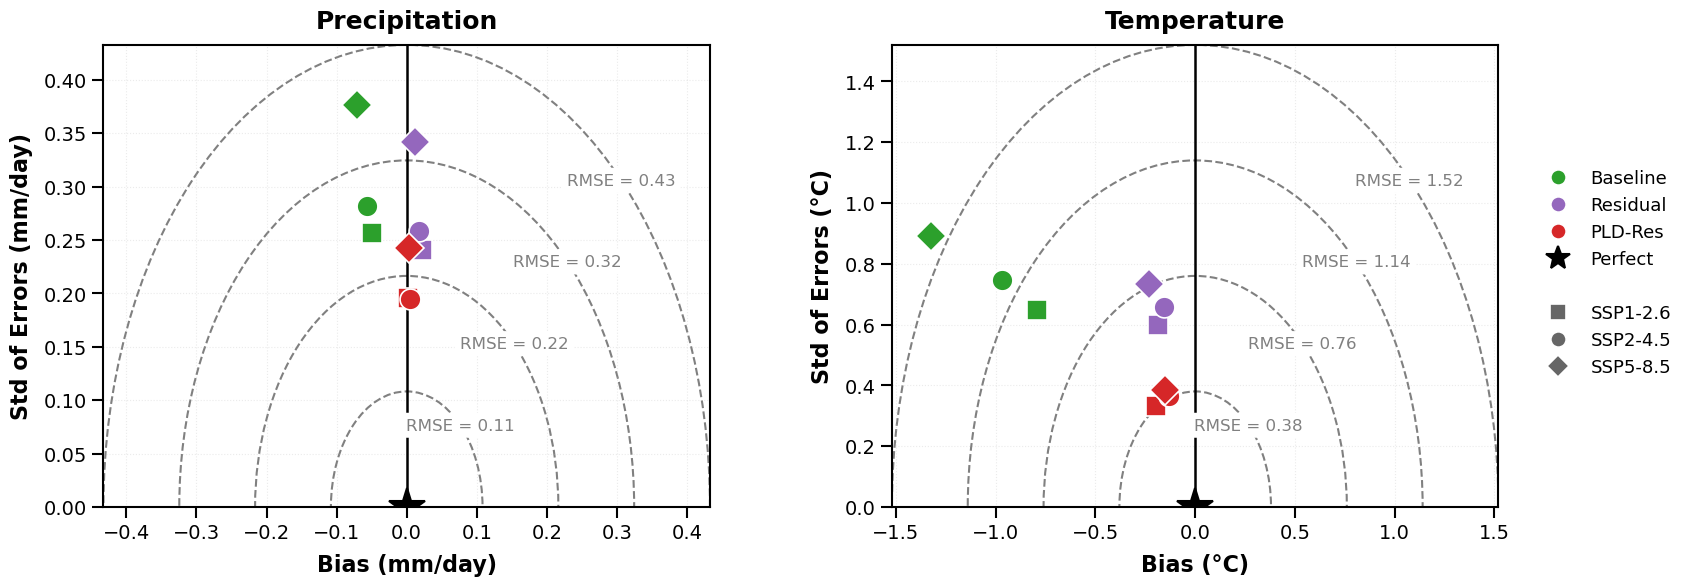

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import matplotlib.lines as mlines
from matplotlib.patches import Circle

# Configuration
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")
figures_dir.mkdir(exist_ok=True)

variables = ['pr', 'tas']
scenarios = ['ssp126', 'ssp245', 'ssp585']  # Removed historical

# Models to compare
models = ['baseline', 'raw_residual', 'pld_residual']  # Only selected models

# Variable configuration
var_config = {
    'pr': {'label': 'Precipitation', 'unit': 'mm/day'},
    'tas': {'label': 'Temperature', 'unit': '°C'}
}

# Model labels
model_labels = {
    'baseline': 'Baseline',
    'raw_residual': 'Residual',
    'pld_residual': 'PLD-Res'
}

# Scenario labels
scenario_labels = {
    'ssp126': 'SSP1-2.6',
    'ssp245': 'SSP2-4.5',
    'ssp585': 'SSP5-8.5'
}

# Colors for models - black, green, purple, red
model_colors = {
    'baseline': '#2ca02c',      # Green
    'raw_residual': '#9467bd',  # Purple
    'pld_residual': '#d62728'   # Red
}

# Marker styles for each scenario
scenario_markers = {
    'ssp126': 's',      # square
    'ssp245': 'o',      # circle (changed from triangle)
    'ssp585': 'D'       # diamond
}

def calculate_bias_std_from_temporal_mean(pred_data, gt_data):
    """
    Calculate bias and standard deviation for target diagram using temporal mean spatial maps.
    """
    # Calculate temporal mean to get 2D spatial maps
    if isinstance(pred_data, xr.DataArray):
        pred_mean_2d = pred_data.mean(dim='time').values
        gt_mean_2d = gt_data.mean(dim='time').values
    else:
        pred_mean_2d = np.mean(pred_data, axis=0)
        gt_mean_2d = np.mean(gt_data, axis=0)
    
    # Flatten spatial dimensions
    pred_flat = pred_mean_2d.flatten()
    gt_flat = gt_mean_2d.flatten()
    
    # Remove NaN values
    mask = ~(np.isnan(pred_flat) | np.isnan(gt_flat))
    pred_flat = pred_flat[mask]
    gt_flat = gt_flat[mask]
    
    # Calculate errors
    errors = pred_flat - gt_flat
    
    # Bias (systematic error)
    bias = np.mean(errors)
    
    # Standard deviation of errors (random error)
    std_error = np.std(errors)
    
    # Total RMSE
    rmse = np.sqrt(np.mean(errors**2))
    
    return bias, std_error, rmse

# Load data and compute statistics
stats = {var: {scen: {} for scen in scenarios} for var in variables}

for var in variables:
    for scenario in scenarios:
        # Load baseline results
        baseline_file = results_dir / f"{var}_evaluation_{scenario}.nc"
        if baseline_file.exists():
            ds_baseline = xr.open_dataset(baseline_file)
            gt_data = ds_baseline['groundtruth']
            
            # Baseline model
            if 'pred_zscore_pixel' in ds_baseline:
                pred_data = ds_baseline['pred_zscore_pixel']
                bias, std_error, rmse = calculate_bias_std_from_temporal_mean(pred_data, gt_data)
                stats[var][scenario]['baseline'] = {
                    'bias': bias,
                    'std_error': std_error,
                    'rmse': rmse
                }
        
        # Load residual model results
        residual_file = results_residual_dir / f"{var}_evaluation_{scenario}.nc"
        if residual_file.exists():
            ds_residual = xr.open_dataset(residual_file)
            gt_data = ds_residual['groundtruth']
            
            model_map = {
                'raw_residual': 'pred_raw',
                'pld_residual': 'pred_grid'
            }
            
            for model_key, data_key in model_map.items():
                if data_key in ds_residual:
                    pred_data = ds_residual[data_key]
                    bias, std_error, rmse = calculate_bias_std_from_temporal_mean(pred_data, gt_data)
                    stats[var][scenario][model_key] = {
                        'bias': bias,
                        'std_error': std_error,
                        'rmse': rmse
                    }

# Create target diagram
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.5

# Create 1x2 subplot figure with new figsize
fig = plt.figure(figsize=(18, 6))  # Changed from (15, 7) to (16, 6)
gs = fig.add_gridspec(1, 2, hspace=0.3, wspace=0.3)

# Plot each variable
for idx, var in enumerate(variables):
    ax = fig.add_subplot(gs[0, idx])
    
    # Find max values for axis limits
    max_bias = 0
    max_std = 0
    
    for scenario in scenarios:
        for model in models:
            if model in stats[var][scenario]:
                max_bias = max(max_bias, abs(stats[var][scenario][model]['bias']))
                max_std = max(max_std, stats[var][scenario][model]['std_error'])
    
    # Add padding
    axis_limit = max(max_bias, max_std) * 1.15
    
    # Draw RMSE circles with dashed lines
    rmse_levels = np.linspace(0, axis_limit, 5)[1:]
    
    for rmse_level in rmse_levels:
        circle = Circle((0, 0), rmse_level, fill=False,
                       edgecolor='gray', linestyle='--',
                       linewidth=1.5, alpha=1.0)  # Changed alpha to 1.0
        ax.add_patch(circle)
        
        # Label circles with increased fontsize
        ax.text(rmse_level * 0.707, rmse_level * 0.707,
               f'RMSE = {rmse_level:.2f}',
               fontsize=12, color='gray', alpha=1.0,  # Changed alpha to 1.0
               ha='center', va='center',
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white',
                        edgecolor='none', alpha=1.0))  # Changed alpha to 1.0
    
    # Draw axes
    ax.axhline(y=0, color='black', linewidth=1.8, alpha=1.0, zorder=2)  # Changed alpha to 1.0
    ax.axvline(x=0, color='black', linewidth=1.8, alpha=1.0, zorder=2)  # Changed alpha to 1.0
    
    # Draw grid
    ax.grid(True, alpha=0.25, linestyle=':', linewidth=0.8, zorder=1)
    
    # Plot reference point (perfect model at origin)
    ax.plot(0, 0, 'k*', markersize=28,  # Increased from 24 to 28
           markeredgecolor='black', markeredgewidth=1.5, zorder=100)
    
    # Plot all model points
    for scenario in scenarios:
        for model in models:
            if model in stats[var][scenario]:
                bias = stats[var][scenario][model]['bias']
                std_error = stats[var][scenario][model]['std_error']
                
                ax.plot(bias, std_error,
                       marker=scenario_markers[scenario],
                       color=model_colors[model],
                       markersize=15,  # Increased from 11 to 15
                       markeredgecolor='white',
                       markeredgewidth=1.2,
                       alpha=1.0,  # Changed alpha to 1.0
                       linestyle='none',
                       zorder=50)
    
    # Set limits
    ax.set_xlim(-axis_limit, axis_limit)
    ax.set_ylim(0, axis_limit)
    
    # Labels with increased fontsize
    ax.set_xlabel(f'Bias ({var_config[var]["unit"]})', 
                 fontsize=16, fontweight='bold', labelpad=8)
    ax.set_ylabel(f'Std of Errors ({var_config[var]["unit"]})', 
                 fontsize=16, fontweight='bold', labelpad=8)
    ax.set_title(var_config[var]['label'], 
                fontsize=18, fontweight='bold', pad=12)
    
    # Improve tick formatting with increased parameters
    ax.tick_params(labelsize=14, length=8, width=1.5)
    
    # Make spines more visible
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)
        spine.set_edgecolor('black')

# Create merged legend
all_handles = []
all_labels = []

# Add models
for model in models:
    handle = mlines.Line2D([], [], color=model_colors[model],
                          marker='o', linestyle='None',
                          markersize=11,  # Increased from 9 to 11
                          markeredgecolor='white', markeredgewidth=1.2)
    all_handles.append(handle)
    all_labels.append(model_labels[model])

# Add reference point
ref_handle = mlines.Line2D([], [], color='black', marker='*',
                          linestyle='None', markersize=18,  # Increased from 16 to 18
                          markeredgecolor='black', markeredgewidth=1.5)
all_handles.append(ref_handle)
all_labels.append('Perfect')

# Add spacing
all_handles.append(mlines.Line2D([], [], linestyle='None', marker='', markersize=0))
all_labels.append('')

# Add scenarios
for scenario in scenarios:
    handle = mlines.Line2D([], [], color='#666666',
                          marker=scenario_markers[scenario],
                          linestyle='None',
                          markersize=11,  # Increased from 9 to 11
                          markeredgecolor='white', markeredgewidth=1.2)
    all_handles.append(handle)
    all_labels.append(scenario_labels[scenario])

# Position legend with increased fontsize and no frame
legend = fig.legend(handles=all_handles, labels=all_labels,
                   loc='center left', bbox_to_anchor=(0.91, 0.5),
                   fontsize=13, frameon=False,
                   borderpad=0.8, labelspacing=0.5)

# Adjust layout
plt.tight_layout(rect=[0, 0, 0.90, 1.0])

# Save figure
output_file = figures_dir / "15_target_diagram_residual.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()